In [1]:
import cv2
import os
from datetime import datetime
from networkx import jaccard_coefficient
import numpy as np
from sympy import fu
import yaml
import time
import logging

from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict
from ultralytics import YOLO

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
hoodFR_holeIdentification = None
hoodFR_clipDetectionModel = None
hoodFR_hanireDetectionModel = None

#Detection Model
path_hoodFR_holeIdentification = "./../models/classify_holes_or_not.pt"
#Classification Model
path_hoodFR_clipDetectionModel = "./../models/detect_clip_and_holes.pt"
path_hoodFR_hanireDetectionModel = "./../models/classify_hanire.pt"

if os.path.exists(path_hoodFR_holeIdentification):
    hoodFR_holeIdentification = YOLO(path_hoodFR_holeIdentification)

if os.path.exists(path_hoodFR_clipDetectionModel):
    hoodFR_clipDetectionModel = AutoDetectionModel.from_pretrained(model_type="yolov8",
                                                                    model_path=path_hoodFR_clipDetectionModel,
                                                                    confidence_threshold=0.5,
                                                                    device="cuda:0")
if os.path.exists(path_hoodFR_hanireDetectionModel):
    hoodFR_hanireDetectionModel = AutoDetectionModel.from_pretrained(model_type="yolov8",
                                                                    model_path=path_hoodFR_hanireDetectionModel,
                                                                    confidence_threshold=0.6,
                                                                    device="cuda:0")

if hoodFR_holeIdentification is not None:
    print("HoodFR Hole Identification Model Initialized")
if hoodFR_clipDetectionModel is not None:
    print("HoodFR Clip Detection Model Initialized")
if hoodFR_hanireDetectionModel is not None:
    print("HoodFR Hanire Detection Model Initialized")

HoodFR Hole Identification Model Initialized
HoodFR Clip Detection Model Initialized


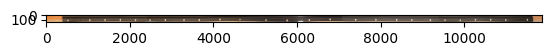

In [3]:
cropImage1 = cv2.imread("./img/part2Crop.png")
plt.imshow(cropImage1)

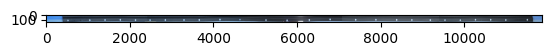

In [4]:
cropImage1 = cv2.cvtColor(cropImage1, cv2.COLOR_BGR2RGB)   
plt.imshow(cropImage1)

In [5]:
InspectionResult_ClipDetection = get_sliced_prediction(
    cropImage1, hoodFR_clipDetectionModel, 
    slice_height=200, slice_width=968, 
    overlap_height_ratio=0.3, overlap_width_ratio=0.2,
    postprocess_match_metric="IOS",
    postprocess_match_threshold=0.2,
    postprocess_class_agnostic=True,
    postprocess_type="GREEDYNMM",
    verbose=0,
    perform_standard_pred=False
)

In [6]:
print (InspectionResult_ClipDetection.object_prediction_list)

[ObjectPrediction<
    bbox: BoundingBox: <(11485.83251953125, 91.84747314453125, 11533.329162597656, 133.5087127685547), w: 47.49664306640625, h: 41.66123962402344>,
    mask: None,
    score: PredictionScore: <value: 0.9612029790878296>,
    category: Category: <id: 0, name: CLIPWHITE>>, ObjectPrediction<
    bbox: BoundingBox: <(2116.1781005859375, 96.74959564208984, 2162.6004028320312, 141.09194946289062), w: 46.42230224609375, h: 44.34235382080078>,
    mask: None,
    score: PredictionScore: <value: 0.9491692781448364>,
    category: Category: <id: 0, name: CLIPWHITE>>, ObjectPrediction<
    bbox: BoundingBox: <(1754.5592651367188, 91.11074829101562, 1800.2188110351562, 135.54888916015625), w: 45.6595458984375, h: 44.438140869140625>,
    mask: None,
    score: PredictionScore: <value: 0.9475018382072449>,
    category: Category: <id: 0, name: CLIPWHITE>>, ObjectPrediction<
    bbox: BoundingBox: <(8361.243835449219, 90.95743560791016, 8407.6796875, 135.84823608398438), w: 46.435

In [7]:
InspectionResult_ClipDetection.export_visuals(export_dir="img", hide_labels=True, hide_conf=True, rect_th=1)

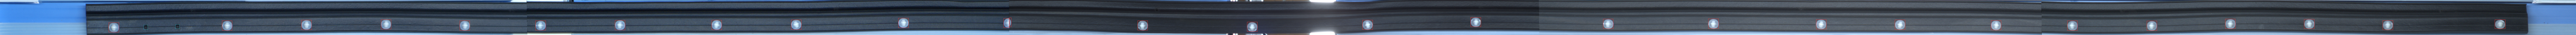

In [8]:
Image.open("./img/prediction_visual.png")


In [28]:
#Check the canny for the image
cropImage1 = cv2.imread("./img/part5Crop.png")

cropImage1_grey = cv2.cvtColor(cropImage1, cv2.COLOR_BGR2GRAY)


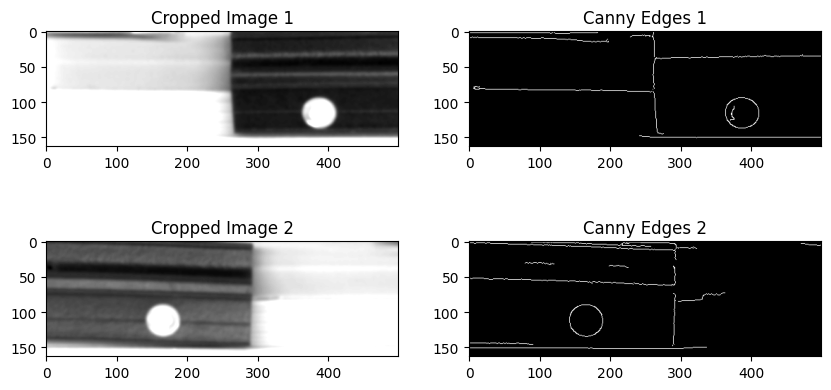

In [32]:

# Parameters
blur = 9
lower_canny = 10
upper_canny = 100
contrast = 2.0  # Set this closer to 1.0 to avoid extreme contrast

# Crop the most left image to see it easily
cropImage1_grey_cropped = cropImage1_grey[0:200, 0:500]
cropImage2_grey_cropped = cropImage1_grey[0:200, 11200:11700]

# Apply Gaussian blur
cropImage1_grey_cropped = cv2.GaussianBlur(cropImage1_grey_cropped, (blur, blur), 0)
cropImage2_grey_cropped = cv2.GaussianBlur(cropImage2_grey_cropped, (blur, blur), 0)

# Adjust contrast (use a more reasonable contrast value)
cropImage1_grey_cropped = cv2.addWeighted(cropImage1_grey_cropped, contrast, np.zeros(cropImage1_grey_cropped.shape, cropImage1_grey_cropped.dtype), 0, 0)
cropImage2_grey_cropped = cv2.addWeighted(cropImage2_grey_cropped, contrast, np.zeros(cropImage2_grey_cropped.shape, cropImage2_grey_cropped.dtype), 0, 0)

# Perform Canny edge detection
edges1 = cv2.Canny(cropImage1_grey_cropped, lower_canny, upper_canny)
edges2 = cv2.Canny(cropImage2_grey_cropped, lower_canny, upper_canny)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.title('Cropped Image 1')
plt.imshow(cropImage1_grey_cropped, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Canny Edges 1')
plt.imshow(edges1, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Cropped Image 2')
plt.imshow(cropImage2_grey_cropped, cmap='gray')

plt.subplot(2, 2, 4)
plt.title('Canny Edges 2')
plt.imshow(edges2, cmap='gray')

plt.show()